In [43]:
from sklearn.cluster import KMeans
from matplotlib import colors
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from collections import defaultdict
import image_slicer
import os

Structure of this program:
1. Import an image
2. Change it to an np array
3. Reduce color
4. Slice
5. Identify blocks
6. Construct a map based on the identified blocks

In [48]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def reduce_colors(image, n_colors):
    arr = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    fewer_colors = centers[labels].reshape(image.shape).astype('uint8')
    return fewer_colors

def slicer(img, row, col):
    #include debris
    dx = img.shape[1]//col
    dy = img.shape[0]//row
    imgls=[]
    for i in range(0, row):
        for j in range(0, col):
            imgls.append(img[i*dy:(i+1)*dy, j*dx:(j+1)*dx])
    output=[]
    for i in range(0,row):
        output.append([0]*col)
    for i in range(0,row):
        for j in range(0,col):
            output[i][j]=imgls[i*col+j]
    return output
    
def identify_land(image):
    height=len(image)
    width=len(image[0])
    water1='#16b2b0'
    water2='#155bdc' 
    tree='#177237' 
    crop='#745617'
    colordict=defaultdict(int)
    for i in image:
        for j in i:
            colordict[RGB2HEX(j)]+=1
    wratio=(colordict[water1]+colordict[water2])/(height*width)
    tratio=colordict[tree]/(height*width)
    cratio=colordict[crop]/(height*width)
    if cratio>0.1:
        return 2
    elif wratio>0.6:
        return 0
    elif tratio>0.18:
        return 1

def Process(fpath, row, col):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=reduce_colors(image, 9)
    subimages=slicer(image, row, col)
    waterset=set()
    cropset=set()
    treeset=set()
    for i in range(0, len(subimages)):
        for j in range(0, len(subimages[i])):
            if identify_land(subimages[i][j])==2:
                cropset.add((i,j))
            elif identify_land(subimages[i][j])==0:
                waterset.add((i,j))
            elif  identify_land(subimages[i][j])==1:
                treeset.add((i,j))
    return cropset, waterset, treeset

def generate_map(rows, cols, cropset=None, waterset=None, treeset=None, protectset=None):
    '''Create A Map'''
    arr=[] 
    for i in range(cols): 
        col = [] 
        for j in range(rows): 
            col.append(0) 
        arr.append(col)
    if cropset!=None:
        for i in cropset:
            arr[i[0]][i[1]]=3
    if waterset!=None:
        for i in waterset:
            arr[i[0]][i[1]]=2
    if treeset!=None:
        for i in treeset:
            arr[i[0]][i[1]]=1
    return np.array(arr)

def plot_map(row, col, cropset, waterset, treeset):
    data = generate_map(row, col, cropset, waterset, treeset)
    # create discrete colormap
    cmap = colors.ListedColormap(['white', 'green', 'blue', 'orange'])
    bounds = [0,1,2,3,4]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(data, cmap=cmap, norm=norm)
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(0, col, 1));
    ax.set_yticks(np.arange(0, row, 1));
    plt.show()

In [49]:
fpath='C:\\Users\\s1760\\Desktop\\map converter\\Okavango.png'

The code below outputs the origial map, a map with "resolution" 16\*16, a map with "resolution" 20\*20, and a map with "resolution" 30\*30.  

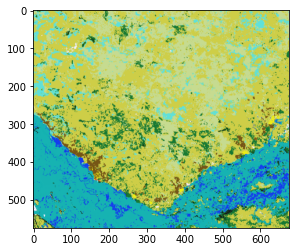

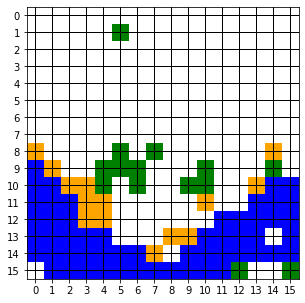

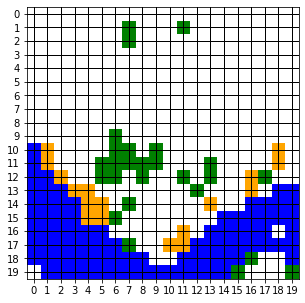

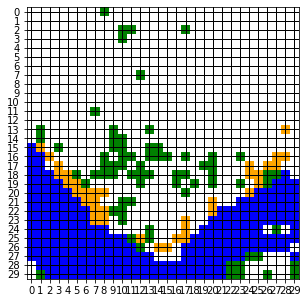

In [50]:
image = cv2.imread('Okavango.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cropset, waterset,treeset=Process(fpath,16,16)
plot_map(16,16,cropset,waterset,treeset)
cropset, waterset,treeset=Process(fpath,20,20)
plot_map(20,20,cropset,waterset,treeset)
cropset, waterset,treeset=Process(fpath,30,30)
plot_map(30,30,cropset,waterset,treeset)